# ELG7186 - Winter 2022 - Assignment 1
## Due: <strong>Sunday February 6<sup>th</sup> 2022 -- 11:59pm</strong>

The purpose of this assignment is to gain some experience working with the tools you will use throughout the course. You will learn:
- The basics of data loading and preparation
- Classification using the k-NN algorithm
- Classification using a Support Vector Machine (SVM)
- Calculation of metrics to assess the performance of your model

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you will submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


## Part 0. Dataset Preparation
To complete the assignment you will need to download the MNIST dataset and devise an appropriate training set split. You may acquire the dataset using the method of your choice. Note that some sources e.g. sklearn have reduced the samples to only 1797 (this could negatively affect your results). If you use the full dataset, you are free to sample from the dataset to reduce the overal training samples. The overall accuracy is less important than your  observations and comparisons. For example classifying the full 10,000 test images might take approximately 15 minutes using k-NN.

In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Divide the raw data into appropriate training and test sets for both the images and corresponding labels for use with the subsequent parts of the assignment.</li>
<li>Visualize five samples of each class by plotting a grid using the matplotlib library.</li>
</ul>


#### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn import preprocessing
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

#### Download the dataset

In [2]:
mnist = fetch_openml('mnist_784',version=1,cache=True,return_X_y=False)

In [3]:
X, y = mnist["data"], mnist["target"]
y = y.astype(int)
print('Data size: {0} x {1} and label size {2}'.format(X.shape[0],X.shape[1],y.shape[0]))

Data size: 70000 x 784 and label size 70000


### take random sample from the dataset

In [4]:
idx = np.random.choice(np.arange(len(X)), 10000, replace=False)
X_sample = X.values[idx]
y_sample = y.values[idx]

#### split it to training and testing sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0, shuffle=True)
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (8000, 784)
Y_train: (8000,)
X_test:  (2000, 784)
Y_test:  (2000,)


#### Visualize five samples of each class

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

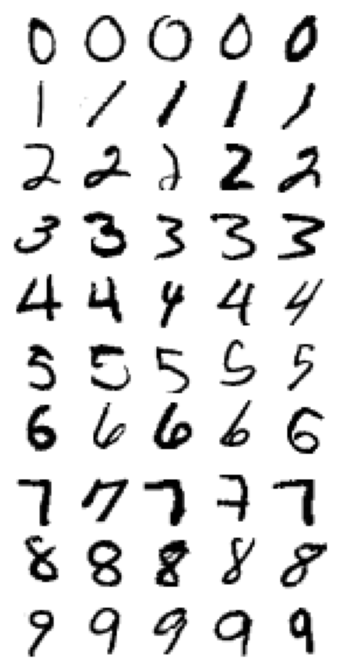

In [ ]:
num_per_row = 5
examples = np.zeros((10*num_per_row,X.shape[1]))

for i in range(10):
    index = np.where(y==i)[0]
    pick = index[np.random.choice(index.shape[0],num_per_row)]
    examples[i*num_per_row:(i+1)*num_per_row,:] = X.iloc[pick,:].values

plt.figure(figsize=(15,12))
plot_digits(examples, images_per_row = num_per_row)
plt.show()

## Part 1. k-NN Classifier (2 Marks)
For this section you will implement a simple kNN Classifier on the MNIST dataset. To do this you will need to perform the following steps:
- Create a k-NN class. Your class must contain a method that returns predictions for your test set.
- Provide a suitable distance metric that you will use to calculate the nearest neightbours. You may choose the distance metric you believe is most suitable.
- Calculate the k nearest neighbours and make predictions.
- Choose the a value for _k_ that results in the highest accuracy on your test set. Show how you found this value.

When your classifier is working:
- Use sklearn to calculate accuracy and plot a confusion matrix using your predictions.
- Provide a brief discussion of your results

### Bonus:

When you compute the distance metric you can acheive better performance if you vectorize the computation instead of using for loops to iterate through the values. You can earn __0.5 bonus marks__ if you only need one loop, or __1 bonus mark__ if you can omit for loops for a fully vectorized distance calculation (a maximum of 1 bonus mark is available).




### Create a k-NN class

In [ ]:
class KNN() : 
      
    def __init__(self, K) :
        self.K = K
        
    def fit(self, X_train, Y_train) :  
        self.X_train = X_train
        self.Y_train = Y_train          
        self.m, self.n = X_train.shape
          
    def predict(self, X_test) :
        self.X_test = X_test          
        self.m_test, self.n = X_test.shape
        Y_predict = np.zeros(self.m_test)
        for i in range(self.m_test) :
            x = self.X_test[i]              
            neighbors = np.zeros(self.K)             
            neighbors = self.find_neighbors(x)              
            Y_predict[i] = mode(neighbors)[0][0]    
        return Y_predict
                  
    def find_neighbors(self, x) :  
        euclidean_distances = np.zeros(self.m)
        for i in range(self.m) :
            d = self.euclidean(x, self.X_train[i])
            euclidean_distances[i] = d
        inds = euclidean_distances.argsort()
        Y_train_sorted = self.Y_train[inds]
        return Y_train_sorted[:self.K]  

    def euclidean( self, x, x_train ) :
        return np.sqrt( np.sum( np.square( x - x_train ) ) )      

In [ ]:
k_acc = []
for k in range(3,15,2):
  knn_model = KNN(K=k)
  knn_model.fit(X_train, y_train)
  y_pred = knn_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  k_acc.append(accuracy)
  print('K = {}, Accuracy = {}'.format(k, accuracy))

K = 3, Accuracy = 0.933
K = 5, Accuracy = 0.93
K = 7, Accuracy = 0.9265
K = 9, Accuracy = 0.929
K = 11, Accuracy = 0.9205
K = 13, Accuracy = 0.919


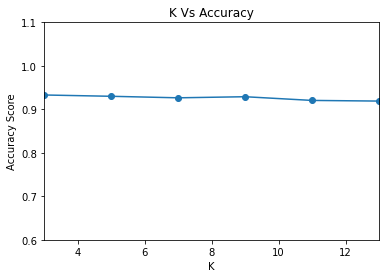

In [ ]:
  plt.plot(range(3,15,2), k_acc, marker = 'o')
  plt.title('K Vs Accuracy')
  plt.xlabel("K")
  plt.ylabel('Accuracy Score')
  plt.ylim(0.6,1.1)
  plt.xlim(3,13)
  plt.show()

#### the best K is 3

#### Use sklearn to calculate accuracy and plot a confusion matrix using your predictions

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3, p=1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

Sklearn KNN Accuracy: 0.9195
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       204
           1       0.85      1.00      0.92       212
           2       0.95      0.89      0.92       227
           3       0.91      0.92      0.92       232
           4       0.95      0.92      0.93       191
           5       0.91      0.90      0.91       175
           6       0.96      0.96      0.96       184
           7       0.89      0.92      0.91       193
           8       0.98      0.78      0.87       186
           9       0.89      0.91      0.90       196

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



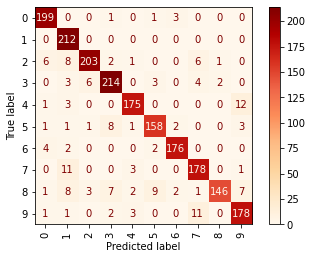

In [ ]:
print(f"Sklearn KNN Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical', cmap=plt.cm.OrRd);

#### Provide a brief discussion of your results

- the KNN class which we build take more time to fit the data than the built in method in sklearn.
- we tried minkowski distance but euclidean distance gives us more accurate results.
- we tried different Ks and the best is K = 3.

## Part 2. Logistic Regression (3 Marks)

For this section you will perform binary classification using logistic regression. Just as in Part 1. you will use the MNIST dataset, however to obtain a result for each class using logistic regression you will need to use a One-vs-Rest (OvR) approach to acheive multi-class classification. 

Using ```LogisticRegression()``` in sklearn, write a function to execute the OvR strategy for the MNIST classes. Do not use the built-in ```OneVsResClassifier()``` method. You will need to follow these basic steps:
- Train a binary classifier for each class, where the target class is a "positive" results and the combination of the remaining classes are "negative". For MNIST you will need 10 models.
- For each test sample compute the probabilities for each model
- Select the argmax of the probabilities to obtain the predicted class

Collect your predictions from the test set and compute the accuracy score and plot a confusion matrix.

In [ ]:
def binarize_label(labels , positive_class):
  ylabels = []
  lb = preprocessing.LabelBinarizer(neg_label = -1, pos_label = 1)
  lb.fit([positive_class])
  y_label_bin = lb.transform(labels)
  for i in range(len(y_label_bin)):
    ylabels.append(y_label_bin[i][0])
  return np.array(ylabels)

In [ ]:
def buid_model(model,X_train, y_train, X_test, y_test, positive_cls):
  y_train_bin = binarize_label(y_train, positive_cls)
  y_test_bin = binarize_label(y_test, positive_cls)
  model.fit(X_train, y_train_bin)
  y_pred_bin= model.predict(X_test)
  y_pred_prob = model.predict_proba(X_test)
  test_acc = accuracy_score(y_test_bin, y_pred_bin)
  print("\n testing accuracy :  "  ,test_acc,"\n")
  return y_pred_bin, y_pred_prob 

#### Model 0

In [ ]:
lr_model_0 = LogisticRegression(multi_class='ovr')
lr_y_preds_0, lr_y_pred_proba_0 = buid_model(lr_model_0, X_train, y_train, X_test, y_test,0)


 testing accuracy :   0.9805 



#### Model 1

In [ ]:
lr_model_1 = LogisticRegression(multi_class='ovr')
lr_y_preds_1, lr_y_pred_proba_1 = buid_model(lr_model_1, X_train, y_train, X_test, y_test,1)


 testing accuracy :   0.9825 



#### Model 2

In [ ]:
lr_model_2 = LogisticRegression(multi_class='ovr')
lr_y_preds_2, lr_y_pred_proba_2 = buid_model(lr_model_2, X_train, y_train, X_test, y_test,2)


 testing accuracy :   0.955 



#### Model 3

In [ ]:
lr_model_3 = LogisticRegression(multi_class='ovr')
lr_y_preds_3, lr_y_pred_proba_3 = buid_model(lr_model_3, X_train, y_train, X_test, y_test,3)


 testing accuracy :   0.9555 



#### Model 4

In [ ]:
lr_model_4 = LogisticRegression(multi_class='ovr')
lr_y_preds_4, lr_y_pred_proba_4= buid_model(lr_model_4, X_train, y_train, X_test, y_test,4)


 testing accuracy :   0.9725 



#### Model 5

In [ ]:
lr_model_5 = LogisticRegression(multi_class='ovr')
lr_y_preds_5, lr_y_pred_proba_5 = buid_model(lr_model_5, X_train, y_train, X_test, y_test,5)


 testing accuracy :   0.964 



#### Model 6

In [ ]:
lr_model_6 = LogisticRegression(multi_class='ovr')
lr_y_preds_6, lr_y_pred_proba_6 = buid_model(lr_model_6, X_train, y_train, X_test, y_test,6)


 testing accuracy :   0.9765 



#### Model 7

In [ ]:
lr_model_7 = LogisticRegression(multi_class='ovr')
lr_y_preds_7, lr_y_pred_proba_7 = buid_model(lr_model_7, X_train, y_train, X_test, y_test,7)


 testing accuracy :   0.9675 



#### Model 8

In [ ]:
lr_model_8 = LogisticRegression(multi_class='ovr')
lr_y_preds_8, lr_y_pred_proba_8 = buid_model(lr_model_8, X_train, y_train, X_test, y_test,8)


 testing accuracy :   0.9335 



#### Model 9

In [ ]:
lr_model_9 = LogisticRegression(multi_class='ovr')
lr_y_preds_9, lr_y_pred_proba_9 = buid_model(lr_model_9, X_train, y_train, X_test, y_test,9)


 testing accuracy :   0.9435 




 Accuracy Score :   0.842 


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       204
           1       0.92      0.94      0.93       212
           2       0.89      0.81      0.85       227
           3       0.85      0.79      0.82       232
           4       0.87      0.87      0.87       191
           5       0.78      0.79      0.78       175
           6       0.89      0.90      0.90       184
           7       0.81      0.88      0.84       193
           8       0.68      0.78      0.73       186
           9       0.80      0.75      0.78       196

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000


Confusion Matrix:



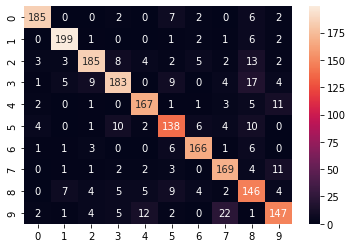

In [ ]:
lr_ypreds = np.argmax([lr_y_pred_proba_0[:,1],lr_y_pred_proba_1[:,1],lr_y_pred_proba_2[:,1], lr_y_pred_proba_3[:,1], lr_y_pred_proba_4[:,1],
                      lr_y_pred_proba_5[:,1], lr_y_pred_proba_6[:,1], lr_y_pred_proba_7[:,1], lr_y_pred_proba_8[:,1], lr_y_pred_proba_9[:,1]], axis=0)

print("\n Accuracy Score :  "  ,round(accuracy_score(y_test, lr_ypreds),3),"\n")
print('\nClassification Report:\n' )
print(classification_report(y_test, lr_ypreds))
print('\nConfusion Matrix:\n' )
cm = confusion_matrix(y_test, lr_ypreds)
f = sns.heatmap(cm, annot=True, fmt='d')

## Part 3. Support Vector Machine (SVM) Classification (4 Marks)

In Part 3. you will use Scikit-learn to perform classification, again on the MNIST dataset. You can use the built in SVM library for classification. As with logistic regression, SVM is designed for binary classification. However, in this case Scikit-learn will handle the OvR models behind the scenes.

Your task is to compare different modes of the SVM and determine the best performer. 

Create an SVM baseline using the <code>LinearSVC()</code> function. Make sure to use the primal solution and use "ovr" for multiclass Calculate the accuracy score for comparison.

Next you will explore the effect of the cost parameter on the accuracy.
    <ul>
    <li>Run the classification with a range of C values For example: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]</li>
    <li>Plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

Add a regularization term.
    <ul>
    <li>Rerun the above experiment, but this time use L1 regularization.</li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

For the final experiment you will use the ```SVC()``` function to run the classifer with a kernel.
    <ul>
    <li>Use a radial basis function when training a new model</li>
    <li>Find the optimal combination of values for the cost and gamma parameters. Use the following values in your loop:<br/>
        <div style="margin-left:40px"><code>
        for cost in [0.01, 0.1, 1, 10, 100]:<br/>
        &emsp;for gamma in [0.01, 0.1, 1, 10, 100]:
        </code></div>
    </li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>


Choose the model with the highest accuracy and plot the confusion matrix. In your discussion explain the results of your experiments and the reason for increased performance from the baseline (if any). Comment on the effect of the cost-paramenter and the L1 penalty on accuracy as well as any overfitting you observed. Discuss the confusion matrix of the model accuracy and provide some reasons for high-values found off the main diagonal.

### Bonus Mark
Instead of using raw pixel values compute an alternate feature representation for your dataset and re-run train the model. Compare the accuracy of the model using the new feature representation with the model trained with pixel values.

### SVM baseline using the LinearSVC()

LinearSVC Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       204
           1       0.94      0.96      0.95       212
           2       0.82      0.86      0.84       227
           3       0.90      0.71      0.79       232
           4       0.90      0.85      0.87       191
           5       0.61      0.88      0.72       175
           6       0.89      0.89      0.89       184
           7       0.85      0.87      0.86       193
           8       0.78      0.62      0.69       186
           9       0.74      0.78      0.76       196

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000


Confusion Matrix:



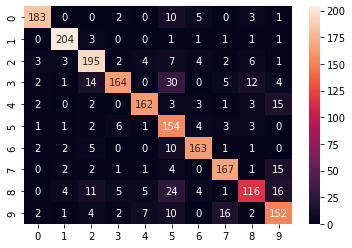

In [ ]:
svm_baseline_model = svm.LinearSVC(multi_class = 'ovr')
svm_baseline_model.fit(X_train, y_train)
svm_ypreds_base = svm_baseline_model.predict(X_test)
print(f"LinearSVC Accuracy: {accuracy_score(y_test, svm_ypreds_base)}")
print(classification_report(y_test, svm_ypreds_base))
print('\nConfusion Matrix:\n' )
cm2 = confusion_matrix(y_test, svm_ypreds_base)
f2 = sns.heatmap(cm2, annot=True, fmt='d')

### Run the classification with a range of C values [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]

In [ ]:
c_acc = []
c_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in c_list:
  svm_model_c = svm.LinearSVC(multi_class = 'ovr', C=c)
  svm_model_c.fit(X_train, y_train)
  svm_ypreds_c = svm_model_c.predict(X_test)
  accuracy_c = accuracy_score(y_test, svm_ypreds_c)
  c_acc.append(accuracy_c)

### Plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.

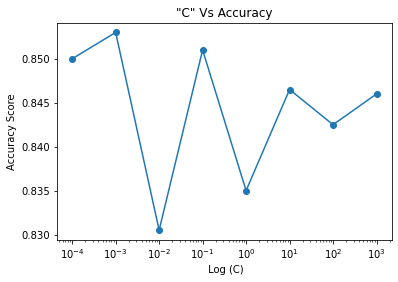

In [ ]:
plt.plot(c_list, c_acc, marker = 'o')
plt.title('"C" Vs Accuracy')
plt.xlabel(" Log (C)")
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.show()

### Rerun the above experiment, but this time use L1 regularization

In [ ]:
c_l1_acc = []
c_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in c_list:
  svm_model_c_l1 = svm.LinearSVC(multi_class = 'ovr', C=c, penalty='l1', loss='squared_hinge', dual= False)
  svm_model_c_l1.fit(X_train, y_train)
  svm_ypreds_c_l1 = svm_model_c_l1.predict(X_test)
  accuracy_c_l1 = accuracy_score(y_test, svm_ypreds_c_l1)
  c_l1_acc.append(accuracy_c_l1)

### plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.

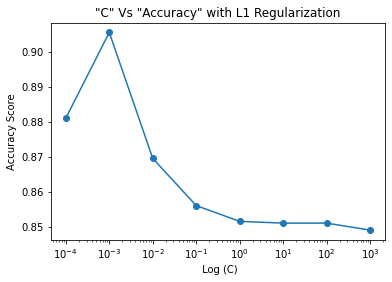

In [ ]:
plt.plot(c_list, c_l1_acc, marker = 'o')
plt.title('"C" Vs "Accuracy" with L1 Regularization')
plt.xlabel(" Log (C)")
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.show()

### Use a radial basis function when training a new model (without scaling)

In [ ]:
svc_acc = []
cost_lst = [0.01, 0.1, 1, 10, 100]
gamma_lst = [0.01, 0.1, 1, 10, 100]
for cost in cost_lst:
  for gamma in gamma_lst:
    svc_model = svm.SVC(kernel='rbf', decision_function_shape="ovr", C= cost, gamma= gamma)
    svc_model.fit(X_train, y_train)
    svc_ypreds = svc_model.predict(X_test)
    accuracy_svc = accuracy_score(y_test, svc_ypreds)
    svc_acc.append(accuracy_svc)
    print(' for cost = {} and gamma = {}, Accuracy = {}'.format(cost, gamma, accuracy_svc))
    print('-------------------------------------------------------------------------')

 for cost = 0.01 and gamma = 0.01, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 0.1, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 1, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 10, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 100, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.1 and gamma = 0.01, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.1 and gamma = 0.1, Accuracy = 0.094
-------------------------------------------------------------------------
 for cost = 0.1 and gamma = 1, Accuracy = 0.094
-------------------------------------------------------------------------
 for c

### plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.

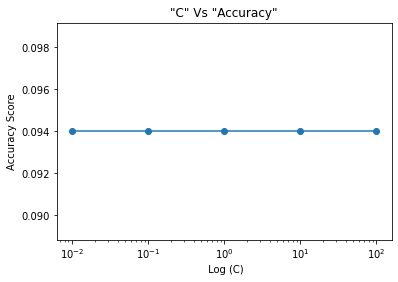

In [ ]:
svc2_acc = [np.max(svc_acc[:5]), np.max(svc_acc[5:10]), np.max(svc_acc[10:15]), np.max(svc_acc[15:20]), np.max(svc_acc[20:25])]
plt.plot(cost_lst, svc2_acc, marker = 'o')
plt.title('"C" Vs "Accuracy"')
plt.xlabel(" Log (C)")
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.show()

### (Bonus) Use a radial basis function when training a new model (with scaling)

In [6]:
scaler = MinMaxScaler()
X_sample_scaled = scaler.fit_transform(X_sample)
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X_sample_scaled, y_sample, test_size=0.2, random_state=0, shuffle=True)

In [7]:
svc_acc2 = []
cost_lst = [0.01, 0.1, 1, 10, 100]
gamma_lst = [0.01, 0.1, 1, 10, 100]
for cost in cost_lst:
  for gamma in gamma_lst:
    svc_model2 = svm.SVC(kernel='rbf', decision_function_shape="ovr", C= cost, gamma= gamma)
    svc_model2.fit(X_train_scale, y_train_scale)
    svc_ypreds2 = svc_model2.predict(X_test_scale)
    accuracy_svc2 = accuracy_score(y_test_scale, svc_ypreds2)
    svc_acc2.append(accuracy_svc2)
    print(' for cost = {} and gamma = {}, Accuracy = {}'.format(cost, gamma, accuracy_svc2))
    print('-------------------------------------------------------------------------')

 for cost = 0.01 and gamma = 0.01, Accuracy = 0.71
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 0.1, Accuracy = 0.109
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 1, Accuracy = 0.109
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 10, Accuracy = 0.109
-------------------------------------------------------------------------
 for cost = 0.01 and gamma = 100, Accuracy = 0.109
-------------------------------------------------------------------------
 for cost = 0.1 and gamma = 0.01, Accuracy = 0.916
-------------------------------------------------------------------------
 for cost = 0.1 and gamma = 0.1, Accuracy = 0.426
-------------------------------------------------------------------------
 for cost = 0.1 and gamma = 1, Accuracy = 0.109
-------------------------------------------------------------------------
 for co

### plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.

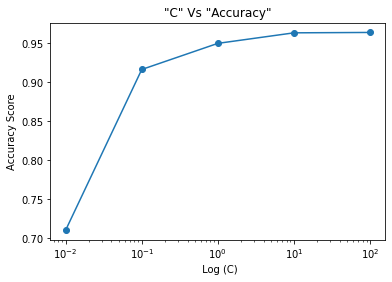

In [8]:
svc2_acc2 = [np.max(svc_acc2[:5]), np.max(svc_acc2[5:10]), np.max(svc_acc2[10:15]), np.max(svc_acc2[15:20]), np.max(svc_acc2[20:25])]
plt.plot(cost_lst, svc2_acc2, marker = 'o')
plt.title('"C" Vs "Accuracy"')
plt.xlabel(" Log (C)")
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.show()

### plot the results as a list of accuracies vs. C-parameter curve on a logarithmic scale.

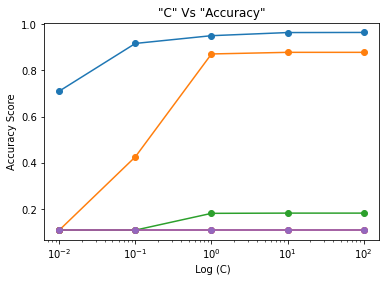

In [15]:
svc2_acc2 = [svc_acc2[:5], svc_acc2[5:10], svc_acc2[10:15], svc_acc2[15:20], svc_acc2[20:25]]
plt.plot(cost_lst, svc2_acc2, marker = 'o')
plt.title('"C" Vs "Accuracy"')
plt.xlabel(" Log (C)")
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.show()

### best combination is cost = 10 and gamma = 0.01

Accuracy is 0.963

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       159
           1       0.96      0.99      0.98       218
           2       0.96      0.97      0.97       196
           3       0.94      0.95      0.94       188
           4       0.98      0.97      0.97       219
           5       0.96      0.93      0.95       200
           6       0.96      0.99      0.97       197
           7       0.99      0.98      0.98       208
           8       0.97      0.92      0.95       209
           9       0.95      0.95      0.95       206

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000


Confusion Matrix:



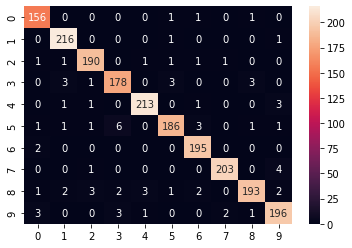

In [16]:
svc_model_best = svm.SVC(kernel='rbf', decision_function_shape="ovr", C= 10, gamma= 0.01)
svc_model_best.fit(X_train_scale, y_train_scale)
svc_ypreds_best = svc_model_best.predict(X_test_scale)
accuracy_svc_best = accuracy_score(y_test_scale, svc_ypreds_best)
print("Accuracy is {}\n".format(accuracy_svc_best))
print(classification_report(y_test_scale, svc_ypreds_best))
print('\nConfusion Matrix:\n' )
cm3 = confusion_matrix(y_test_scale, svc_ypreds_best)
f3 = sns.heatmap(cm3, annot=True, fmt='d')

### Discussion

- the baseline accuraccy using LinearSVC is 83%.
- after adding cost paramter (C) with different values, the accuracy start to increase and reaches to 86%.
- after changing the regularization paramter from 'L2' to 'L1' which panelizes the sum of absolute value of weights, try different values of cost (C), the accuracy reaches to 91% since L1 is suitable for images.
- last experiment with SVC using 'rbf' kerenel with cost (C) and gamma without scaling the data, the accuracy is not good (10%).
- after scaling the data and rerun the algorithm we got higher accuracy reaches over 90%.
- the best combination was cost = 10 and gamma = 0.01 and accuracy increases to 96%.
- from the confusion matrix, we noticed that the values in the main diagonal are high that's indicate our model performs well on the testset and predicts most of the values correct.
- but if we investigate the values off diagonal, we noticed that thet are relatively small, for example for class 5 the model misclassifies 6 values as class 3 and so on.

## Part 4. Write a Conclusion (1 Mark)

Write a conclusion comparing the results from each part of the assignment. Comment on the suitability of each method for this task.

**Part 0 :**
- loading mnist data from scikit-learn (70000) images.
- taking random sample of 10000 from the data, because whole data is more computational.
- spliting the sample into training(80%) and testing(20%).
- visualizing five random samples for each class.

**Part 1 :**
- it's great experiment to implement KNN from scratch to know how it's work behind the scene.
- we used euclidean method to compute distance.
- try different number of K to get the best one.
- comparing the performance and time between the build in from scickit learn and the algorithm which we built from scratch.
- the KNN class taking more time to fit because there are 2 nasted loops.
- final accuracy using KNN class is 93% and using built in is 91%.
- it`s good accuracy but the algorithm is memory consuming (Lazy Learning).

**Part 2 :**
- creating 1 binary model (Logistic Regression) for each class.
- calculate probabilities for each data point in the testset.
- use argmax to calculate the final predictions.
-  the final accuracy using this approach is 84% which is not good.

**Part 3 :**
- the baseline accuraccy using LinearSVC is 83%.
- after adding cost paramter (C) with different values, the accuracy start to increase and reaches to 86%.
- after changing the regularization paramter from 'L2' to 'L1' which panelizes the sum of absolute value of weights, try different values of cost (C), the accuracy reaches to 91% since L1 is suitable for images.
- last experiment with SVC using 'rbf' kerenel with cost (C) and gamma without scaling the data, the accuracy is not good (10%).
- after scaling the data and rerun the algorithm we got higher accuracy reaches over 90%.
- the best combination was cost = 10 and gamma = 0.01 and accuracy increases to 96%.
- this is the best acccuracy we have reached during this experiment.